# PhysioNet Motor Imagery Dataset - Comprehensive EDA

## Exploratory Data Analysis

This notebook provides a comprehensive exploratory data analysis of the PhysioNet Motor Imagery dataset.

### Objectives:
1. **Subject-level Analysis** - Distribution, quality metrics, and characteristics
2. **Run-level Analysis** - Event distribution, duration, quality flags
3. **Signal Quality Assessment** - Amplitude, noise, artifacts
4. **Data Quality Visualization** - Identify clean vs suspect subjects
5. **Task Distribution** - Motor execution vs motor imagery balance
6. **Statistical Insights** - Correlations, distributions, outliers

## 1. Setup and Imports

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Load PhysioNet Data

In [2]:
data_dir = Path('../data/physionet/derived')

subject_summary = pd.read_csv(data_dir / 'physionet_subject_summary.csv')
run_summary = pd.read_csv(data_dir / 'physionet_run_summary.csv')
good_subjects = pd.read_csv(data_dir / 'physionet_good_subjects.csv')
good_runs = pd.read_csv(data_dir / 'physionet_good_runs.csv')
all_runs = pd.read_csv(data_dir / 'physionet_all_runs_with_flags.csv')

print(f"Loaded data:")
print(f"  Total subjects: {len(subject_summary)}")
print(f"  Good subjects: {len(good_subjects)}")
print(f"  Total runs: {len(run_summary)}")
print(f"  Good runs: {len(good_runs)}")
print(f"  All runs with flags: {len(all_runs)}")
print(f"\nSubject summary columns: {list(subject_summary.columns)}")
print(f"\nFirst few subjects:")
subject_summary.head()

Loaded data:
  Total subjects: 109
  Good subjects: 109
  Total runs: 1526
  Good runs: 669
  All runs with flags: 1526

Subject summary columns: ['subject', 'runs_available', 'categories_observed', 'total_duration_s', 'total_events', 'total_label_1', 'total_label_2', 'median_mean_std_uv', 'min_mean_std_uv', 'max_mean_std_uv', 'avg_clip_fraction', 'max_clip_fraction', 'median_line_noise_ratio', 'max_line_noise_ratio', 'runs_with_flat_channels', 'runs_with_noisy_channels', 'runs_with_amp_issue', 'runs_with_zscore_outlier', 'suspect_subject']

First few subjects:


,subject,runs_available,categories_observed,total_duration_s,total_events,total_label_1,total_label_2,median_mean_std_uv,min_mean_std_uv,max_mean_std_uv,avg_clip_fraction,max_clip_fraction,median_line_noise_ratio,max_line_noise_ratio,runs_with_flat_channels,runs_with_noisy_channels,runs_with_amp_issue,runs_with_zscore_outlier,suspect_subject
0,S001,14,"motor_execution, motor_imagery, resting_state",1621.9125,362,90,90,55.642007,50.814924,66.935085,0.008840,0.020742,NaN,NaN,0,1,5,0,True
1,S063,14,"motor_execution, motor_imagery, resting_state",1597.9125,362,89,91,62.719325,56.060463,76.706361,0.002215,0.006256,NaN,NaN,0,0,1,0,True
2,S079,14,"motor_execution, motor_imagery, resting_state",1621.9125,362,88,92,90.666722,65.044682,126.394254,0.046291,0.126211,NaN,NaN,0,13,13,0,True
3,S078,14,"motor_execution, motor_imagery, resting_state",1597.9125,362,90,90,37.013879,28.876362,45.086617,0.007593,0.012600,NaN,NaN,0,2,3,0,True
4,S077,14,"motor_execution, motor_imagery, resting_state",1597.9125,362,87,93,107.572991,88.185766,139.747010,0.090543,0.212652,NaN,NaN,0,14,14,0,True


## 3. Dataset Overview Statistics

In [3]:
print("="*80)
print("PHYSIONET MOTOR IMAGERY DATASET OVERVIEW")
print("="*80)
print(f"\nSubject Statistics:")
print(f"  Total subjects: {len(subject_summary)}")
print(f"  Good quality subjects: {len(good_subjects)} ({len(good_subjects)/len(subject_summary)*100:.1f}%)")
print(f"  Suspect subjects: {subject_summary['suspect_subject'].sum()} ({subject_summary['suspect_subject'].sum()/len(subject_summary)*100:.1f}%)")

print(f"\nRun Statistics:")
print(f"  Total runs: {len(run_summary)}")
print(f"  Good quality runs: {len(good_runs)} ({len(good_runs)/len(run_summary)*100:.1f}%)")
print(f"  Runs per subject: {subject_summary['runs_available'].mean():.1f} ± {subject_summary['runs_available'].std():.1f}")

print(f"\nEvent Statistics:")
print(f"  Total events across all runs: {subject_summary['total_events'].sum():,}")
print(f"  Events per subject: {subject_summary['total_events'].mean():.1f} ± {subject_summary['total_events'].std():.1f}")
print(f"  Total label 1 (Left): {subject_summary['total_label_1'].sum():,}")
print(f"  Total label 2 (Right): {subject_summary['total_label_2'].sum():,}")
print(f"  Balance ratio (L:R): {subject_summary['total_label_1'].sum() / subject_summary['total_label_2'].sum():.3f}")

print(f"\nRecording Duration:")
total_hours = subject_summary['total_duration_s'].sum() / 3600
print(f"  Total recording time: {total_hours:.1f} hours")
print(f"  Duration per subject: {subject_summary['total_duration_s'].mean()/60:.1f} ± {subject_summary['total_duration_s'].std()/60:.1f} minutes")

print(f"\nSignal Quality Metrics:")
print(f"  Median std (µV): {subject_summary['median_mean_std_uv'].median():.2f}")
print(f"  Range: [{subject_summary['min_mean_std_uv'].min():.2f}, {subject_summary['max_mean_std_uv'].max():.2f}]")
print(f"  Avg clip fraction: {subject_summary['avg_clip_fraction'].mean():.4f} ({subject_summary['avg_clip_fraction'].mean()*100:.2f}%)")

print("\n" + "="*80)

PHYSIONET MOTOR IMAGERY DATASET OVERVIEW

Subject Statistics:
  Total subjects: 109
  Good quality subjects: 109 (100.0%)
  Suspect subjects: 76 (69.7%)

Run Statistics:
  Total runs: 1526
  Good quality runs: 669 (43.8%)
  Runs per subject: 14.0 ± 0.0

Event Statistics:
  Total events across all runs: 39,569
  Events per subject: 363.0 ± 15.0
  Total label 1 (Left): 9,858
  Total label 2 (Right): 9,818
  Balance ratio (L:R): 1.004

Recording Duration:
  Total recording time: 48.5 hours
  Duration per subject: 26.7 ± 0.2 minutes

Signal Quality Metrics:
  Median std (µV): 51.30
  Range: [10.13, 253.40]
  Avg clip fraction: 0.0284 (2.84%)



## 4. Subject Quality Distribution

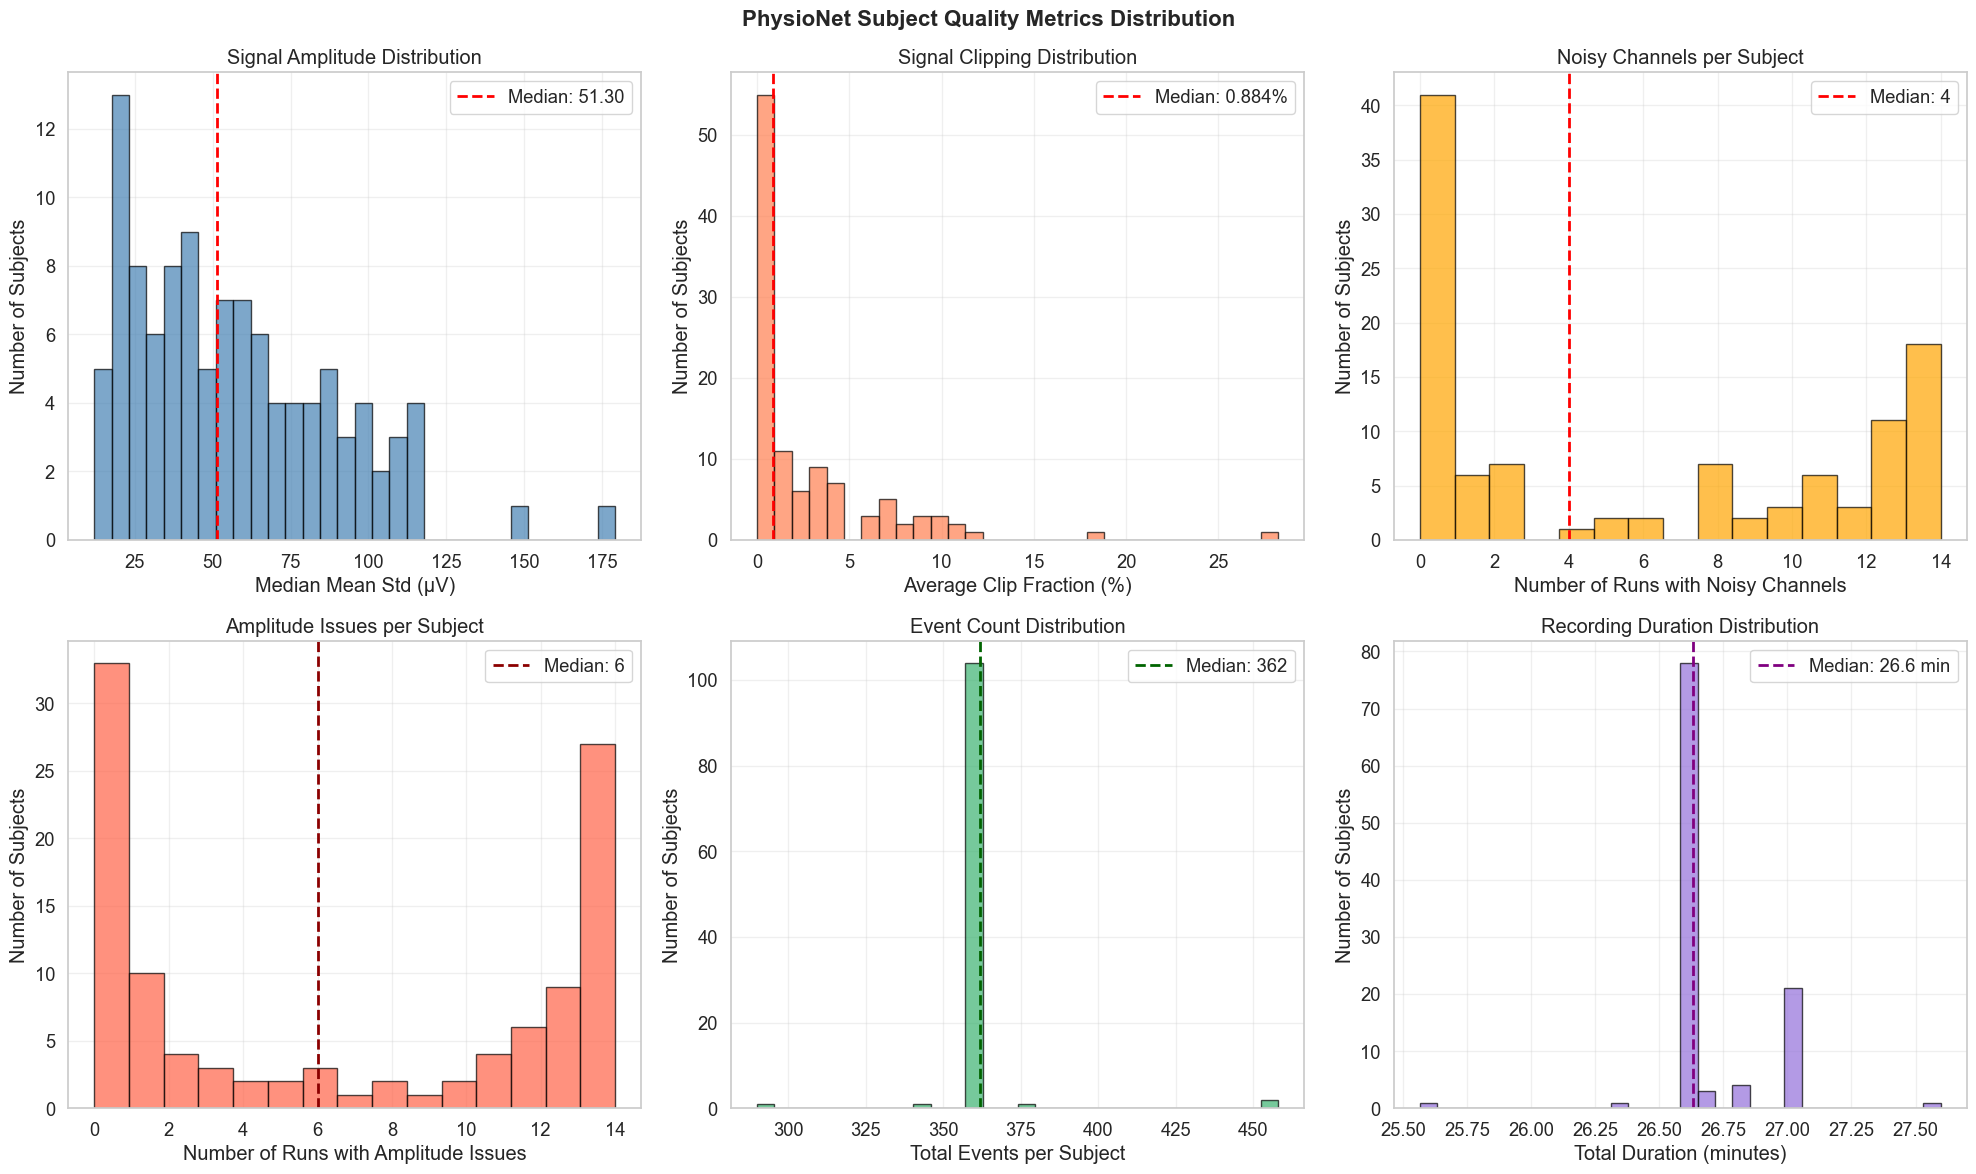

Quality metrics distribution plot saved!


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('PhysioNet Subject Quality Metrics Distribution', fontsize=16, fontweight='bold')

axes[0, 0].hist(subject_summary['median_mean_std_uv'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(subject_summary['median_mean_std_uv'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {subject_summary["median_mean_std_uv"].median():.2f}')
axes[0, 0].set_xlabel('Median Mean Std (µV)')
axes[0, 0].set_ylabel('Number of Subjects')
axes[0, 0].set_title('Signal Amplitude Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(subject_summary['avg_clip_fraction']*100, bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[0, 1].axvline(subject_summary['avg_clip_fraction'].median()*100, color='red', linestyle='--', linewidth=2, label=f'Median: {subject_summary["avg_clip_fraction"].median()*100:.3f}%')
axes[0, 1].set_xlabel('Average Clip Fraction (%)')
axes[0, 1].set_ylabel('Number of Subjects')
axes[0, 1].set_title('Signal Clipping Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].hist(subject_summary['runs_with_noisy_channels'], bins=15, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].axvline(subject_summary['runs_with_noisy_channels'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {subject_summary["runs_with_noisy_channels"].median():.0f}')
axes[0, 2].set_xlabel('Number of Runs with Noisy Channels')
axes[0, 2].set_ylabel('Number of Subjects')
axes[0, 2].set_title('Noisy Channels per Subject')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].hist(subject_summary['runs_with_amp_issue'], bins=15, alpha=0.7, color='tomato', edgecolor='black')
axes[1, 0].axvline(subject_summary['runs_with_amp_issue'].median(), color='darkred', linestyle='--', linewidth=2, label=f'Median: {subject_summary["runs_with_amp_issue"].median():.0f}')
axes[1, 0].set_xlabel('Number of Runs with Amplitude Issues')
axes[1, 0].set_ylabel('Number of Subjects')
axes[1, 0].set_title('Amplitude Issues per Subject')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(subject_summary['total_events'], bins=30, alpha=0.7, color='mediumseagreen', edgecolor='black')
axes[1, 1].axvline(subject_summary['total_events'].median(), color='darkgreen', linestyle='--', linewidth=2, label=f'Median: {subject_summary["total_events"].median():.0f}')
axes[1, 1].set_xlabel('Total Events per Subject')
axes[1, 1].set_ylabel('Number of Subjects')
axes[1, 1].set_title('Event Count Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].hist(subject_summary['total_duration_s']/60, bins=30, alpha=0.7, color='mediumpurple', edgecolor='black')
axes[1, 2].axvline(subject_summary['total_duration_s'].median()/60, color='purple', linestyle='--', linewidth=2, label=f'Median: {subject_summary["total_duration_s"].median()/60:.1f} min')
axes[1, 2].set_xlabel('Total Duration (minutes)')
axes[1, 2].set_ylabel('Number of Subjects')
axes[1, 2].set_title('Recording Duration Distribution')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('physionet_eda_quality_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Quality metrics distribution plot saved!")

## 5. Good vs Suspect Subjects Comparison

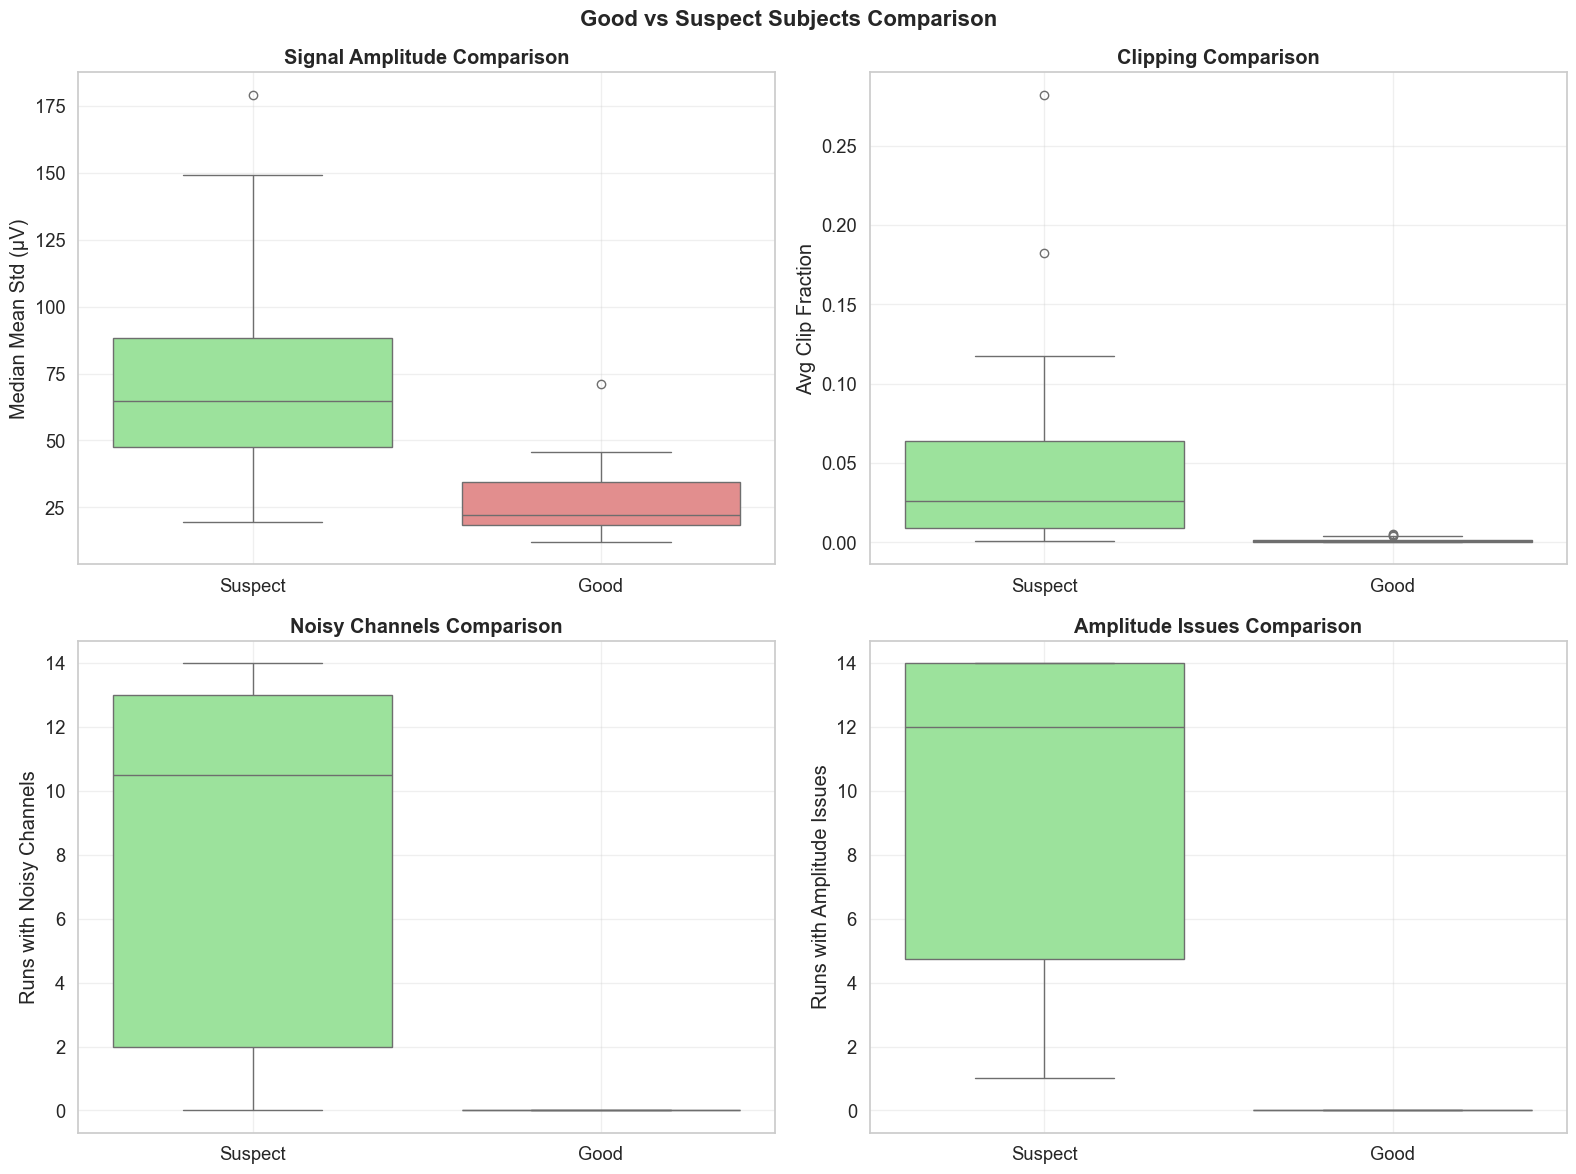


Statistical comparison (t-test):
  median_mean_std_uv: t=-7.709, p=0.0000 ***
  avg_clip_fraction: t=-4.853, p=0.0000 ***
  runs_with_noisy_channels: t=-9.176, p=0.0000 ***
  runs_with_amp_issue: t=-10.798, p=0.0000 ***


In [5]:
subject_summary['quality'] = subject_summary['suspect_subject'].apply(lambda x: 'Suspect' if x else 'Good')

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Good vs Suspect Subjects Comparison', fontsize=16, fontweight='bold')

sns.boxplot(data=subject_summary, x='quality', y='median_mean_std_uv', ax=axes[0, 0], palette=['lightgreen', 'lightcoral'])
axes[0, 0].set_title('Signal Amplitude Comparison', fontweight='bold')
axes[0, 0].set_ylabel('Median Mean Std (µV)')
axes[0, 0].set_xlabel('')
axes[0, 0].grid(True, alpha=0.3)

sns.boxplot(data=subject_summary, x='quality', y='avg_clip_fraction', ax=axes[0, 1], palette=['lightgreen', 'lightcoral'])
axes[0, 1].set_title('Clipping Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Avg Clip Fraction')
axes[0, 1].set_xlabel('')
axes[0, 1].grid(True, alpha=0.3)

sns.boxplot(data=subject_summary, x='quality', y='runs_with_noisy_channels', ax=axes[1, 0], palette=['lightgreen', 'lightcoral'])
axes[1, 0].set_title('Noisy Channels Comparison', fontweight='bold')
axes[1, 0].set_ylabel('Runs with Noisy Channels')
axes[1, 0].set_xlabel('')
axes[1, 0].grid(True, alpha=0.3)

sns.boxplot(data=subject_summary, x='quality', y='runs_with_amp_issue', ax=axes[1, 1], palette=['lightgreen', 'lightcoral'])
axes[1, 1].set_title('Amplitude Issues Comparison', fontweight='bold')
axes[1, 1].set_ylabel('Runs with Amplitude Issues')
axes[1, 1].set_xlabel('')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('physionet_eda_good_vs_suspect.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nStatistical comparison (t-test):")
for col in ['median_mean_std_uv', 'avg_clip_fraction', 'runs_with_noisy_channels', 'runs_with_amp_issue']:
    good_vals = subject_summary[~subject_summary['suspect_subject']][col]
    suspect_vals = subject_summary[subject_summary['suspect_subject']][col]
    t_stat, p_val = stats.ttest_ind(good_vals, suspect_vals)
    print(f"  {col}: t={t_stat:.3f}, p={p_val:.4f} {'***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'}")

## 6. Task Balance Analysis (Left vs Right)

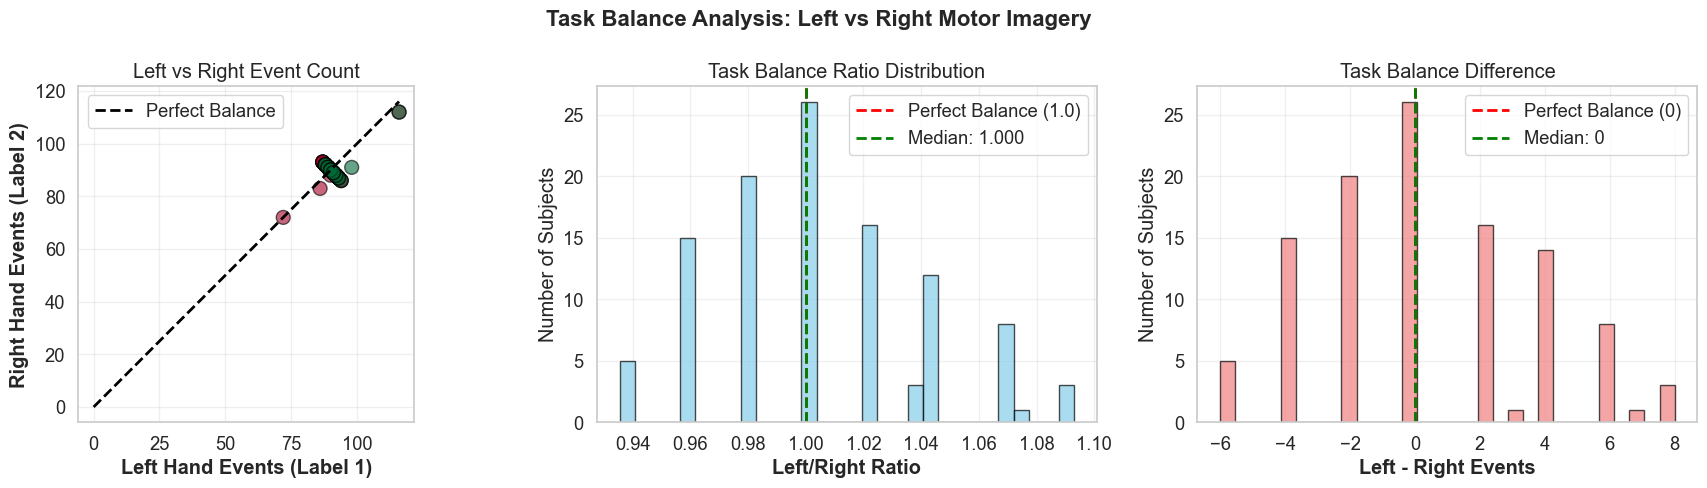


Task Balance Summary:
  Mean balance ratio: 1.005 ± 0.039
  Subjects with perfect balance (ratio between 0.95-1.05): 92
  Max imbalance: 1.093 (Subject S021)


In [6]:
subject_summary['label_balance_ratio'] = subject_summary['total_label_1'] / subject_summary['total_label_2']
subject_summary['label_diff'] = subject_summary['total_label_1'] - subject_summary['total_label_2']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Task Balance Analysis: Left vs Right Motor Imagery', fontsize=16, fontweight='bold')

axes[0].scatter(subject_summary['total_label_1'], subject_summary['total_label_2'], 
                c=subject_summary['suspect_subject'], cmap='RdYlGn_r', s=100, alpha=0.6, edgecolors='black')
axes[0].plot([0, subject_summary[['total_label_1', 'total_label_2']].max().max()], 
             [0, subject_summary[['total_label_1', 'total_label_2']].max().max()], 
             'k--', linewidth=2, label='Perfect Balance')
axes[0].set_xlabel('Left Hand Events (Label 1)', fontweight='bold')
axes[0].set_ylabel('Right Hand Events (Label 2)', fontweight='bold')
axes[0].set_title('Left vs Right Event Count')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal')

axes[1].hist(subject_summary['label_balance_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='Perfect Balance (1.0)')
axes[1].axvline(subject_summary['label_balance_ratio'].median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {subject_summary["label_balance_ratio"].median():.3f}')
axes[1].set_xlabel('Left/Right Ratio', fontweight='bold')
axes[1].set_ylabel('Number of Subjects')
axes[1].set_title('Task Balance Ratio Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].hist(subject_summary['label_diff'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2].axvline(0, color='red', linestyle='--', linewidth=2, label='Perfect Balance (0)')
axes[2].axvline(subject_summary['label_diff'].median(), color='green', linestyle='--', linewidth=2, 
                label=f'Median: {subject_summary["label_diff"].median():.0f}')
axes[2].set_xlabel('Left - Right Events', fontweight='bold')
axes[2].set_ylabel('Number of Subjects')
axes[2].set_title('Task Balance Difference')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('physionet_eda_task_balance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nTask Balance Summary:")
print(f"  Mean balance ratio: {subject_summary['label_balance_ratio'].mean():.3f} ± {subject_summary['label_balance_ratio'].std():.3f}")
print(f"  Subjects with perfect balance (ratio between 0.95-1.05): {((subject_summary['label_balance_ratio'] >= 0.95) & (subject_summary['label_balance_ratio'] <= 1.05)).sum()}")
print(f"  Max imbalance: {subject_summary['label_balance_ratio'].max():.3f} (Subject {subject_summary.loc[subject_summary['label_balance_ratio'].idxmax(), 'subject']})")

## 7. Correlation Analysis

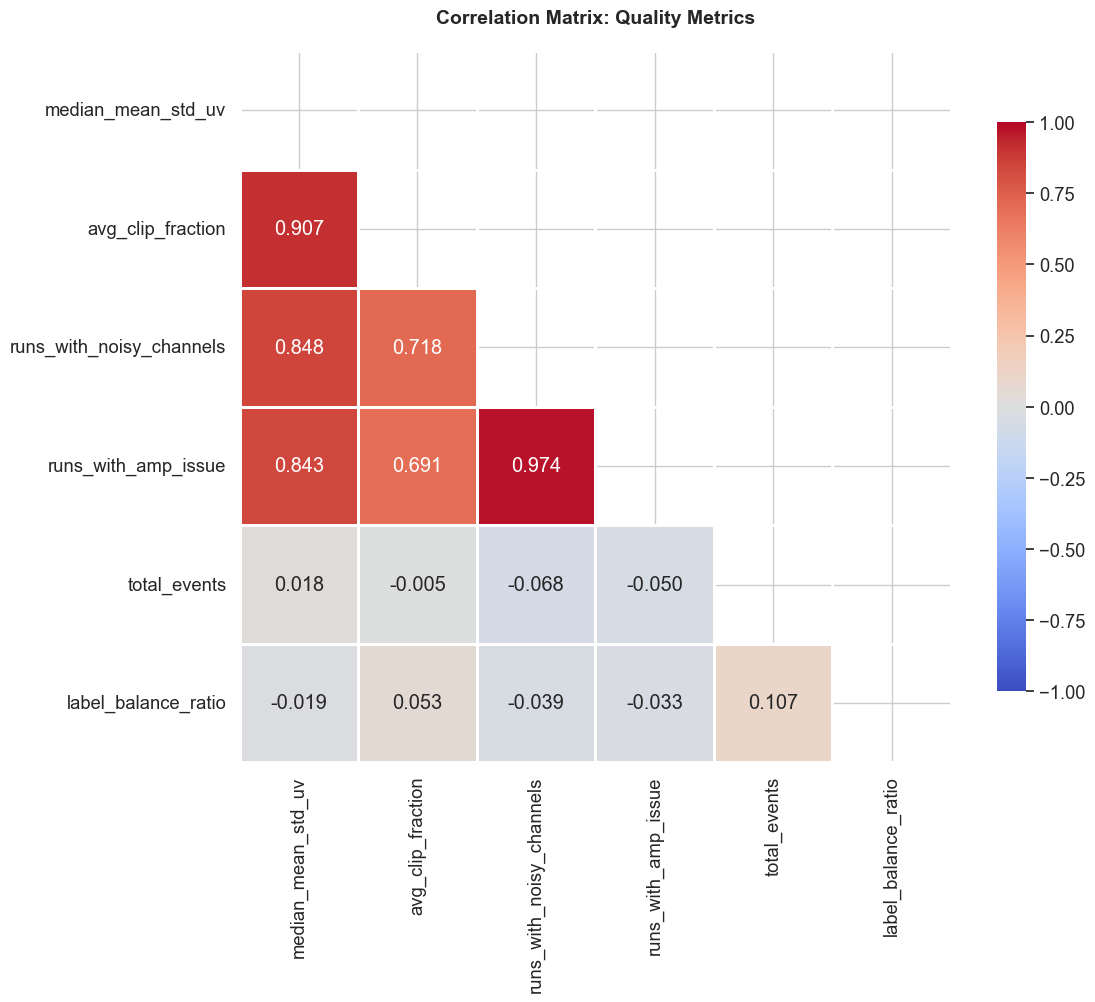


Top 5 Positive Correlations:
  1. runs_with_amp_issue <-> runs_with_noisy_channels: 0.974
  2. avg_clip_fraction <-> median_mean_std_uv: 0.907
  3. runs_with_noisy_channels <-> median_mean_std_uv: 0.848
  4. runs_with_amp_issue <-> median_mean_std_uv: 0.843
  5. runs_with_noisy_channels <-> avg_clip_fraction: 0.718

Top 5 Negative Correlations:
  1. label_balance_ratio <-> median_mean_std_uv: -0.019
  2. label_balance_ratio <-> runs_with_amp_issue: -0.033
  3. label_balance_ratio <-> runs_with_noisy_channels: -0.039
  4. total_events <-> runs_with_amp_issue: -0.050
  5. total_events <-> runs_with_noisy_channels: -0.068


In [7]:
corr_cols = ['median_mean_std_uv', 'avg_clip_fraction', 'runs_with_noisy_channels', 
             'runs_with_amp_issue', 'total_events', 'label_balance_ratio']
corr_matrix = subject_summary[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix: Quality Metrics', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('physionet_eda_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 Positive Correlations:")
corr_flat = corr_matrix.where(~mask).stack().sort_values(ascending=False)
for i, (idx, val) in enumerate(corr_flat.head(5).items()):
    print(f"  {i+1}. {idx[0]} <-> {idx[1]}: {val:.3f}")

print("\nTop 5 Negative Correlations:")
for i, (idx, val) in enumerate(corr_flat.tail(5).items()):
    print(f"  {i+1}. {idx[0]} <-> {idx[1]}: {val:.3f}")

## 8. Interactive Plotly Visualizations

In [8]:
fig = px.scatter(subject_summary, 
                 x='median_mean_std_uv', 
                 y='avg_clip_fraction',
                 color='suspect_subject',
                 size='total_events',
                 hover_data=['subject', 'runs_available', 'runs_with_noisy_channels'],
                 labels={'median_mean_std_uv': 'Signal Amplitude (µV)',
                         'avg_clip_fraction': 'Clipping Fraction',
                         'suspect_subject': 'Suspect?',
                         'total_events': 'Total Events'},
                 title='Subject Quality: Amplitude vs Clipping',
                 color_discrete_map={True: 'red', False: 'green'})

fig.update_layout(height=600, width=1000)
fig.write_html('physionet_eda_interactive_quality.html')
fig.show()

print("Interactive plot saved as 'physionet_eda_interactive_quality.html'")

Interactive plot saved as 'physionet_eda_interactive_quality.html'


In [9]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Signal Amplitude Distribution', 'Clip Fraction Distribution',
                    'Noisy Channels Distribution', 'Amplitude Issues Distribution'),
    specs=[[{'type': 'histogram'}, {'type': 'histogram'}],
           [{'type': 'histogram'}, {'type': 'histogram'}]]
)

good_subjects_df = subject_summary[~subject_summary['suspect_subject']]
suspect_subjects_df = subject_summary[subject_summary['suspect_subject']]

fig.add_trace(go.Histogram(x=good_subjects_df['median_mean_std_uv'], name='Good', marker_color='lightgreen', opacity=0.7), row=1, col=1)
fig.add_trace(go.Histogram(x=suspect_subjects_df['median_mean_std_uv'], name='Suspect', marker_color='lightcoral', opacity=0.7), row=1, col=1)

fig.add_trace(go.Histogram(x=good_subjects_df['avg_clip_fraction'], name='Good', marker_color='lightgreen', opacity=0.7, showlegend=False), row=1, col=2)
fig.add_trace(go.Histogram(x=suspect_subjects_df['avg_clip_fraction'], name='Suspect', marker_color='lightcoral', opacity=0.7, showlegend=False), row=1, col=2)

fig.add_trace(go.Histogram(x=good_subjects_df['runs_with_noisy_channels'], name='Good', marker_color='lightgreen', opacity=0.7, showlegend=False), row=2, col=1)
fig.add_trace(go.Histogram(x=suspect_subjects_df['runs_with_noisy_channels'], name='Suspect', marker_color='lightcoral', opacity=0.7, showlegend=False), row=2, col=1)

fig.add_trace(go.Histogram(x=good_subjects_df['runs_with_amp_issue'], name='Good', marker_color='lightgreen', opacity=0.7, showlegend=False), row=2, col=2)
fig.add_trace(go.Histogram(x=suspect_subjects_df['runs_with_amp_issue'], name='Suspect', marker_color='lightcoral', opacity=0.7, showlegend=False), row=2, col=2)

fig.update_xaxes(title_text="Signal Amplitude (µV)", row=1, col=1)
fig.update_xaxes(title_text="Clip Fraction", row=1, col=2)
fig.update_xaxes(title_text="Runs with Noisy Channels", row=2, col=1)
fig.update_xaxes(title_text="Runs with Amp Issues", row=2, col=2)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=2)
fig.update_yaxes(title_text="Count", row=2, col=1)
fig.update_yaxes(title_text="Count", row=2, col=2)

fig.update_layout(title_text="Interactive Quality Metrics: Good vs Suspect Subjects", height=800, showlegend=True)
fig.write_html('physionet_eda_interactive_comparison.html')
fig.show()

print("Interactive comparison plot saved as 'physionet_eda_interactive_comparison.html'")

Interactive comparison plot saved as 'physionet_eda_interactive_comparison.html'


## 9. Subject Ranking by Quality

TOP 20 HIGHEST QUALITY SUBJECTS
subject  quality_score  suspect_subject  median_mean_std_uv  avg_clip_fraction  runs_with_noisy_channels  total_events
   S037       0.999987            False           12.906979           0.000045                         0           362
   S029       0.999962            False           26.044143           0.000126                         0           362
   S025       0.999957            False           19.317405           0.000143                         0           362
   S051       0.999918            False           16.313872           0.000273                         0           362
   S073       0.999897            False           18.571438           0.000343                         0           362
   S006       0.999689            False           24.574304           0.001038                         0           362
   S085       0.998858            False           30.864443           0.003807                         0           362
   S066       0.

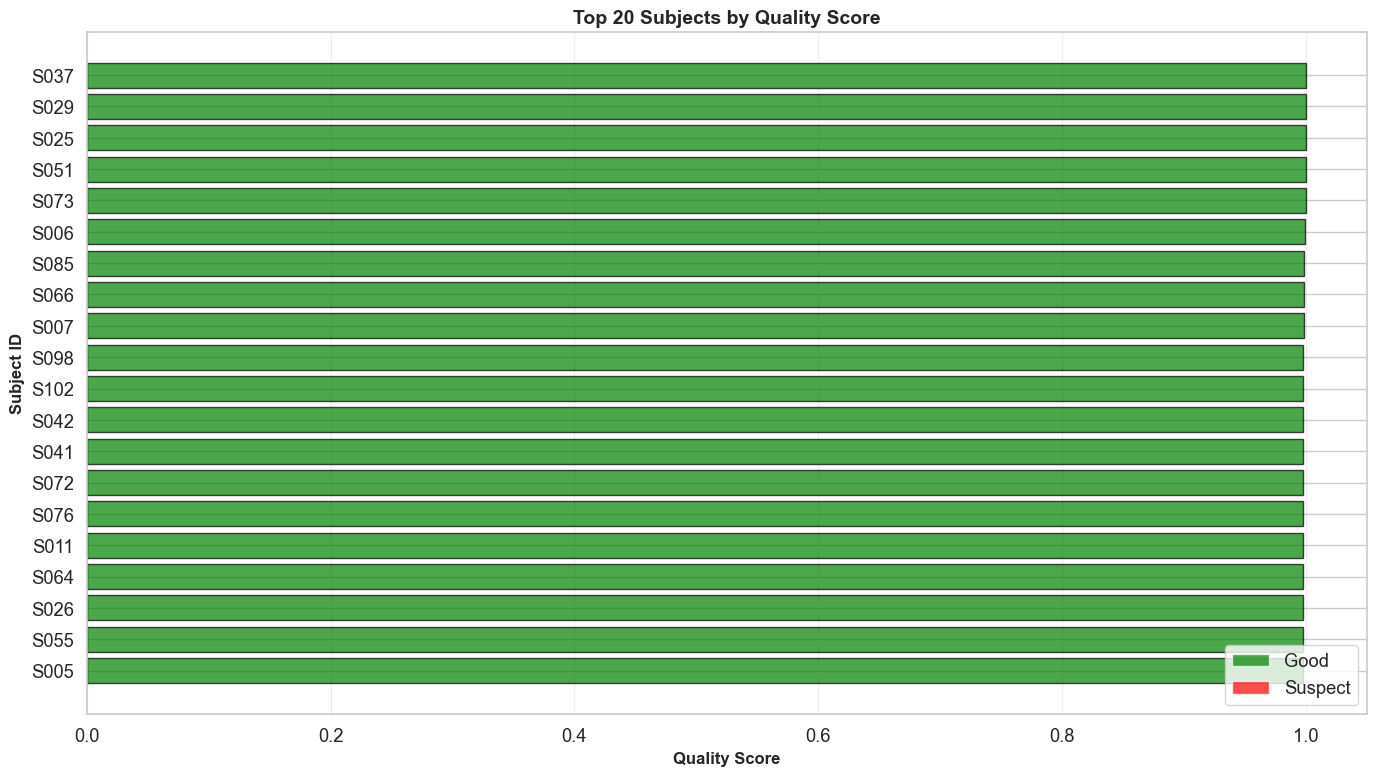

In [10]:
subject_summary['quality_score'] = (
    (1 - subject_summary['avg_clip_fraction']) * 0.3 +
    (1 - subject_summary['runs_with_noisy_channels'] / subject_summary['runs_available']) * 0.3 +
    (1 - subject_summary['runs_with_amp_issue'] / subject_summary['runs_available']) * 0.3 +
    (1 - np.abs(subject_summary['label_balance_ratio'] - 1.0)) * 0.1
)

top_subjects = subject_summary.nlargest(20, 'quality_score')[['subject', 'quality_score', 'suspect_subject', 
                                                                 'median_mean_std_uv', 'avg_clip_fraction', 
                                                                 'runs_with_noisy_channels', 'total_events']]

print("="*100)
print("TOP 20 HIGHEST QUALITY SUBJECTS")
print("="*100)
print(top_subjects.to_string(index=False))
print("="*100)

fig, ax = plt.subplots(figsize=(14, 8))
colors = ['green' if not suspect else 'red' for suspect in top_subjects['suspect_subject']]
bars = ax.barh(top_subjects['subject'], top_subjects['quality_score'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Quality Score', fontweight='bold', fontsize=12)
ax.set_ylabel('Subject ID', fontweight='bold', fontsize=12)
ax.set_title('Top 20 Subjects by Quality Score', fontweight='bold', fontsize=14)
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Good'),
                   Patch(facecolor='red', alpha=0.7, label='Suspect')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('physionet_eda_top_subjects.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Summary Statistics Table

In [11]:
summary_stats = subject_summary.describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary_stats.columns = ['Mean', 'Std', 'Min', 'Q1', 'Median', 'Q3', 'Max']

print("="*120)
print("PHYSIONET DATASET SUMMARY STATISTICS")
print("="*120)
print(summary_stats.to_string())
print("="*120)

summary_stats.to_csv('physionet_eda_summary_stats.csv')
print("\nSummary statistics saved to 'physionet_eda_summary_stats.csv'")

PHYSIONET DATASET SUMMARY STATISTICS
                                 Mean        Std          Min           Q1       Median           Q3          Max
runs_available              14.000000   0.000000    14.000000    14.000000    14.000000    14.000000    14.000000
total_duration_s          1602.884461  12.832460  1533.912500  1597.912500  1597.912500  1601.912500  1655.912500
total_events               363.018349  14.974040   290.000000   362.000000   362.000000   362.000000   458.000000
total_label_1               90.440367   4.349183    72.000000    89.000000    90.000000    91.000000   116.000000
total_label_2               90.073394   3.912720    72.000000    89.000000    90.000000    91.000000   112.000000
median_mean_std_uv          56.838561  32.501553    12.026943    30.514817    51.295820    77.246464   179.168300
min_mean_std_uv             44.510880  25.605595    10.125399    24.924092    40.281127    58.034686   145.667404
max_mean_std_uv             77.692375  44.467364   

## 11. Final EDA Report

In [12]:
print("="*100)
print("PHYSIONET MOTOR IMAGERY EDA - FINAL REPORT")
print("="*100)

print("\n1. DATASET COMPOSITION:")
print(f"   - Total subjects: {len(subject_summary)}")
print(f"   - Good quality: {len(good_subjects)} ({len(good_subjects)/len(subject_summary)*100:.1f}%)")
print(f"   - Suspect quality: {subject_summary['suspect_subject'].sum()} ({subject_summary['suspect_subject'].sum()/len(subject_summary)*100:.1f}%)")
print(f"   - Total recording time: {subject_summary['total_duration_s'].sum()/3600:.1f} hours")

print("\n2. SIGNAL QUALITY:")
print(f"   - Median amplitude: {subject_summary['median_mean_std_uv'].median():.2f} µV")
print(f"   - Clipping rate: {subject_summary['avg_clip_fraction'].mean()*100:.3f}%")
print(f"   - Subjects with zero clipping: {(subject_summary['avg_clip_fraction'] == 0).sum()}")

print("\n3. DATA QUALITY ISSUES:")
print(f"   - Subjects with noisy channels: {(subject_summary['runs_with_noisy_channels'] > 0).sum()} ({(subject_summary['runs_with_noisy_channels'] > 0).sum()/len(subject_summary)*100:.1f}%)")
print(f"   - Subjects with amplitude issues: {(subject_summary['runs_with_amp_issue'] > 0).sum()} ({(subject_summary['runs_with_amp_issue'] > 0).sum()/len(subject_summary)*100:.1f}%)")
print(f"   - Subjects with flat channels: {(subject_summary['runs_with_flat_channels'] > 0).sum()}")

print("\n4. TASK BALANCE:")
print(f"   - Overall Left/Right ratio: {subject_summary['total_label_1'].sum() / subject_summary['total_label_2'].sum():.3f}")
print(f"   - Well-balanced subjects (0.95-1.05): {((subject_summary['label_balance_ratio'] >= 0.95) & (subject_summary['label_balance_ratio'] <= 1.05)).sum()}")
print(f"   - Total events: {subject_summary['total_events'].sum():,}")

print("\n5. RECOMMENDATIONS:")
print(f"   - Use {len(good_subjects)} good quality subjects for modeling")
print(f"   - Consider excluding {subject_summary['suspect_subject'].sum()} suspect subjects")
print(f"   - Focus on subjects with quality_score > {subject_summary['quality_score'].quantile(0.75):.3f}")
print(f"   - Monitor subjects with high clipping (> 5%): {(subject_summary['avg_clip_fraction'] > 0.05).sum()}")

print("\n" + "="*100)
print("EDA COMPLETE! All visualizations and statistics have been generated.")
print("="*100)

PHYSIONET MOTOR IMAGERY EDA - FINAL REPORT

1. DATASET COMPOSITION:
   - Total subjects: 109
   - Good quality: 109 (100.0%)
   - Suspect quality: 76 (69.7%)
   - Total recording time: 48.5 hours

2. SIGNAL QUALITY:
   - Median amplitude: 51.30 µV
   - Clipping rate: 2.836%
   - Subjects with zero clipping: 2

3. DATA QUALITY ISSUES:
   - Subjects with noisy channels: 68 (62.4%)
   - Subjects with amplitude issues: 76 (69.7%)
   - Subjects with flat channels: 0

4. TASK BALANCE:
   - Overall Left/Right ratio: 1.004
   - Well-balanced subjects (0.95-1.05): 92
   - Total events: 39,569

5. RECOMMENDATIONS:
   - Use 109 good quality subjects for modeling
   - Consider excluding 76 suspect subjects
   - Focus on subjects with quality_score > 0.995
   - Monitor subjects with high clipping (> 5%): 21

EDA COMPLETE! All visualizations and statistics have been generated.
